<a href="https://colab.research.google.com/github/mkxdxdxd/AIGS538/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_k_medoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Settings

### 1) Import required libraries

In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl

from google.colab import files

### 2) Hyperparameters

In [2]:
learning_rate = 1e-3
batch_size = 100
epochs = 3000

# 2. Data

### 1) Generate data

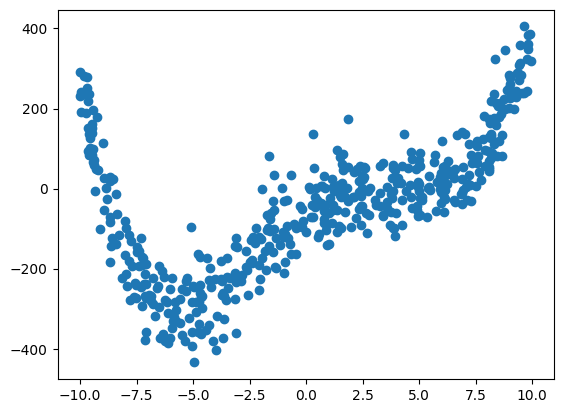

499


In [3]:
np.random.seed(1)
X = [np.random.uniform(-10,10) for _ in range(1, 500)]
X = torch.tensor(X,dtype=torch.float32)
Y = [0.1*(value+9)*((value-4)**3) for value in X]

Y_gauss = Y+np.random.normal(0, 60, 499)
Y_gauss = torch.tensor(Y_gauss,dtype=torch.float32)
plt.plot(X,Y_gauss,'o')
plt.show()
print(len(X))

In [4]:
X = X.unsqueeze(1)
Y_gauss = Y_gauss.unsqueeze(1)

In [5]:
#dataset tensor로 변환
X_train, X_test, y_train, y_test = train_test_split(X,Y_gauss, test_size=0.6, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size=0.5, random_state=42)
#dataset 나누기
print("train:", len(X_test))
print("test:", len(X_test))
print("val:", len(X_valid))

train: 150
test: 150
val: 150


In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_valid, y_valid)

### 2) Dataset reduction

In [7]:
!pip install scikit-learn-extra
#!conda install -c conda-forge scikit-learn-extra

In [8]:
from sklearn_extra.cluster import KMedoids
cluster_dic = {} # centroid 저장
cluster_data_num = {} # 각 cluster에 속한 sample 개수 저장

n_training_samples = len(X_train)
for i in range(1,11): #from 1% to 10%, create 10 different sets of clusters
  #print(round(n_training_samples*i*0.01))
  n_clusters = int(n_training_samples*i*0.01) #1%부터 10%까지
  if n_clusters == 0:
    continue
  sample = np.c_[X_train, y_train]
  kmedoid = KMedoids(n_clusters=n_clusters, random_state=0, init='random') ## KMedoid 초기화
  kmedoid.fit(sample) ## 클러스터링 알고리즘 수행
  labels = torch.tensor(kmedoid.labels_) ## 클러스터링 결과
  centroids = kmedoid.cluster_centers_
  cluster_dic[n_clusters] = centroids
  cluster_data_num[n_clusters] = np.unique(kmedoid.labels_, return_counts=True)[1]

for i in range(15,100,5): #from 15% to 100%, create 18 different sets of clusters
  #print(round(n_training_samples*i*0.01))
  n_clusters = int(n_training_samples*i*0.01) #15%부터 100%까지
  sample = np.c_[X_train, y_train]
  kmedoid = KMedoids(n_clusters=n_clusters, random_state=0,init='random') ## KMeans 초기화
  kmedoid.fit(sample) ## 클러스터링 알고리즘 수행
  labels = torch.tensor(kmedoid.labels_) ## 클러스터링 결과
  centroids = kmedoid.cluster_centers_
  cluster_dic[n_clusters] = centroids
  cluster_data_num[n_clusters] = np.unique(kmedoid.labels_, return_counts=True)[1]

#clustering results, where key is n_clusters, value is centroids
print(cluster_dic.keys())
#print(cluster_data_num)

dict_keys([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189])


dict_keys([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189])


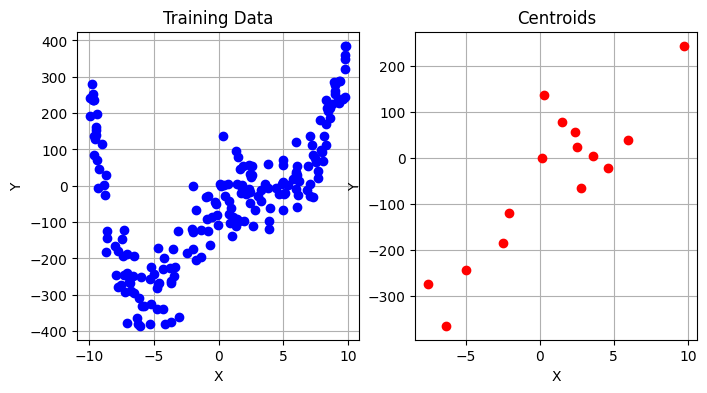

In [9]:
print(cluster_dic.keys())
# dict_keys([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189])

key =15
x_cord = [pair[0] for pair in cluster_dic[key]]
y_cord = [pair[1] for pair in cluster_dic[key]]
weights = cluster_data_num[key]

# Plotting
# Plotting training data
plt.figure(figsize=(8, 4))  # Create a new figure
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot in the 1st column
plt.plot(X_train, y_train, marker='o', linestyle='', color='blue')
plt.title('Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Plotting centroids
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot in the 2nd column
plt.plot(x_cord, y_cord, marker='o', linestyle='', color='red')
plt.title('Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# 3. Training with reduced samples



### 1) Define model

In [10]:
class DNN(nn.Module):
  def __init__(self, input_size=1, output_size=1, hidden_units=30, num_hidden_layers=3):
    super(DNN, self).__init__()
    self.input_layer = nn.Linear(input_size, hidden_units)
    self.hidden_layers = nn.ModuleList([
        nn.Linear(hidden_units, hidden_units) for _ in range(num_hidden_layers)
    ])
    self.output_layer = nn.Linear(hidden_units, output_size)
  def forward(self, x):
    x = torch.relu(self.input_layer(x))
    for layer in self.hidden_layers:
      x = torch.relu(layer(x))
    x = self.output_layer(x)
    return x

### 2) Training

In [11]:
test_loss_history = {}
train_loss_history = {}

def train_loop(dataloader, model, loss_fn, optimizer,i):
    size = len(dataloader.dataset)
    for batch, (X, y, W) in enumerate(dataloader):
        # prediction and loss calculation
        pred = model(X)
        loss = loss_fn(pred, y)
        weighted_loss = torch.mean(W*loss)
        # Backward propagation
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = weighted_loss.item(), (batch + 1) * len(X)
            if i not in train_loss_history: train_loss_history[i] = []
            train_loss_history[i].append(loss)
            # print(f"Training Loss: {loss:>7f}")


def test_loop(dataloader, model, loss_fn,i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).mean().item() #calculate test loss
    test_loss /= num_batches
    if i not in test_loss_history: test_loss_history[i] = []
    test_loss_history[i].append(test_loss)
    # print(f"Test Loss(Avg.): {test_loss:>8f} \n")

def final_test_loss(dataloader, model, loss_fn,i):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          pred = model(X)
          test_loss += loss_fn(pred, y).mean().item() #calculate test loss
    test_loss /= num_batches
    return test_loss

In [12]:
final_capacity = {}
final_valid = {}
final_test = {}

key = 189 # key = dict_keys([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189])
weights = cluster_data_num[key]
weight_coordinates = []
data_pairs = cluster_dic[key]
X_train_reduced = torch.tensor([pair[0] for pair in data_pairs], dtype=torch.float32)
y_train_reduced = torch.tensor([pair[1] for pair in data_pairs], dtype=torch.float32)
X_train_reduced  = X_train_reduced.unsqueeze(1)
y_train_reduced  = y_train_reduced.unsqueeze(1)

weights_tensor = torch.tensor(weights, dtype=torch.float32)
train_dataset = TensorDataset(X_train_reduced, y_train_reduced, weights_tensor)

dataloaders = {}
dataloaders['train_reduced'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
model = {}
device = "cpu"
for i in range (1,11):
  model[i] = DNN(num_hidden_layers=i).to(device)
  loss_func = nn.MSELoss(reduction='none')
  optimizer= torch.optim.Adam(model[i].parameters(), lr=learning_rate)

  for t in range(epochs):
      print("for cluster number: ", key)
      print("# of hidden layer: ", i)
      print(f"Epoch {t+1}")
      train_loop(dataloaders['train_reduced'], model[i], loss_func, optimizer,i)
      test_loop(dataloaders['val'], model[i], loss_func,i)

      print(f"---------------------\n")
print(f"Training done! for cluster {key}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 806
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 807
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 808
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 809
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 810
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 811
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 812
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 813
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 814
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 815
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 816
---------------------

for cluster number:  189
# of hidden layer:  2
Epoch 817
----

KeyboardInterrupt: 

In [15]:
capacity_loss = {}

for i in range(1,11):
  capacity_loss[i] = test_loss_history[i][-1] #최종적인 validation loss를 기록한다.

#그래프 저장
keys = list(capacity_loss.keys())
values = list(capacity_loss.values())

# Convert to PyTorch tensors
keys_tensor = torch.tensor(keys, dtype=torch.float32)
values_tensor = torch.tensor(values, dtype=torch.float32)

optimal_i = min(capacity_loss, key=capacity_loss.get) #vadiation loss가 가장 적었던 capacity i를 선택한다.
optimal_valid = capacity_loss[optimal_i]
optimal_test = final_test_loss(dataloaders['test'], model[optimal_i], loss_func,i)

final_capacity[key] = optimal_i
final_valid[key] = optimal_valid
final_test[key] = optimal_test

### 2.5) Learning curve 그리기

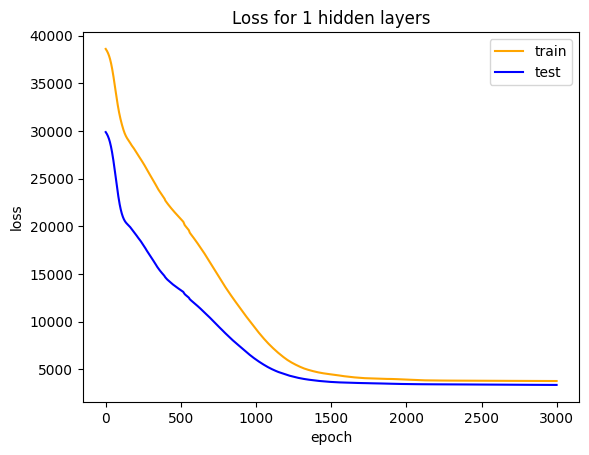

Final Val Loss for 1 hidden layers at final epoch:  3359.9013671875


In [17]:
i = optimal_i
plt.plot(train_loss_history[i], label='train', color = 'orange')
plt.plot(test_loss_history[i], label='test', color = 'blue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'Loss for {i} hidden layers')
plt.legend()

plt.show()
capacity_loss = {}

for i in range(1,11):
  print(f"Final Val Loss for {i} hidden layers at final epoch: ", test_loss_history[i][-1])
  capacity_loss[i] = test_loss_history[i][-1]

### 3) True Function vs Model Prediction

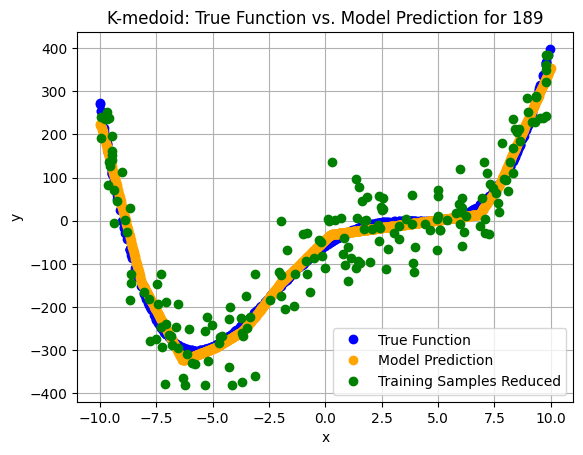

In [18]:
x = torch.linspace(-10, 10, 1000).unsqueeze(1)
plt.figure()
plt.plot(X, Y, 'o', label='True Function', color = 'blue')
plt.plot(x, model[optimal_i](x).detach().numpy(),'o', label='Model Prediction', color = 'orange')
plt.plot(X_train_reduced, y_train_reduced, 'o', label = 'Training Samples Reduced', color = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'K-medoid: True Function vs. Model Prediction for {key}')
plt.grid(True)
# plt.savefig(f'k-medoid: graph for cluster {key}.png')
# files.download(f'k-medoid: graph for cluster {key}.png')
plt.legend()
plt.show()

### 4) Model Selection

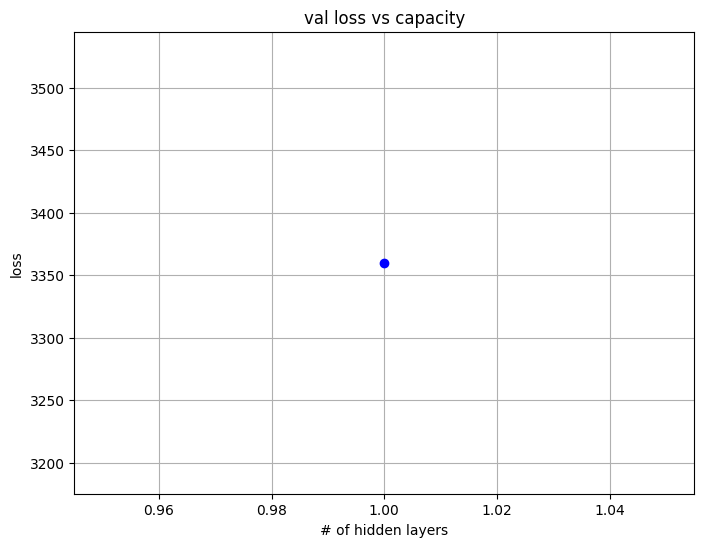

In [19]:
# key, value 추출하기
keys = list(capacity_loss.keys())
values = list(capacity_loss.values())

keys_tensor = torch.tensor(keys, dtype=torch.float32)
values_tensor = torch.tensor(values, dtype=torch.float32)

# plot하기
plt.figure(figsize=(8, 6))
plt.plot(keys_tensor.numpy(), values_tensor.numpy(), marker='o', linestyle='-', color='b')
plt.xlabel('# of hidden layers')
plt.ylabel('loss')
plt.title('val loss vs capacity')
plt.grid(True)
plt.show()

### 5) Results

In [ ]:
print(final_capacity)
print(final_valid)
print(final_test)